In [ ]:
!pip install -q accelerate bitsandbytes datasets peft tokenizers transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 44.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.2 MB/s eta 0:00:00


In [6]:
# push model to hub
!huggingface-cli login --token $(cat secrets.txt)

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
    Trainer,
    DataCollatorForLanguageModeling,
    TextIteratorStreamer
)
from peft import (
    LoraConfig,
    PeftConfig,
    PeftModel,
    get_peft_model,
    prepare_model_for_kbit_training,
)

from threading import Thread

import json
import os

import bitsandbytes as bnb
import pandas as pd
import torch
import torch.nn as nn
import transformers

from datasets import load_dataset

In [ ]:
# quantisation config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

# load model
MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.1"
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    trust_remote_code=True,
    quantization_config=bnb_config,
)

# load tokeniser
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.eos_token == tokenizer.pad_token  # check is True

tokenizer.pad_token = tokenizer.eos_token
# This caused the the model to unlearn the eos token as the stopping criteria.
# tokenizer.pad_token = tokenizer.unk_token


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

In [ ]:
# PEFT - save memory
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)
print(model)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )

In [ ]:
# LORA and PEFT
config = LoraConfig(
    r=64,
    lora_alpha=16,
    target_modules=['q_proj', 'k_proj', 'down_proj', 'v_proj', 'gate_proj', 'o_proj', 'up_proj'], # do not change lm_head
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)



In [ ]:
# prepare dataset - note, no need to combine in excel
import pandas as pd
!pip install -qqq datasets
final_dataset_df = pd.read_excel("final_dataset_v2.0.xlsx", engine='openpyxl', sheet_name='Sheet1')
nus_sms_df = final_dataset_df.iloc[:216, :]
ice_data_df = final_dataset_df.iloc[216:, :]



from datasets import Dataset, DatasetDict, concatenate_datasets

seed = 42
# account for stratified sampling
nus_sms_data = Dataset.from_pandas(nus_sms_df)
nus_sms_data = nus_sms_data.train_test_split(test_size=0.2, seed=seed)
sms_test_and_eval = nus_sms_data["test"].train_test_split(test_size=0.4, seed=seed)
nus_sms_data["test"] = sms_test_and_eval["train"]
nus_sms_data["eval"] = sms_test_and_eval["test"]

#print(nus_sms_data)
ice_data = Dataset.from_pandas(ice_data_df)
ice_data = ice_data.train_test_split(test_size=0.2, seed=seed)
ice_test_and_eval = ice_data["test"].train_test_split(test_size=0.4, seed=seed)
ice_data["test"] = ice_test_and_eval["train"]
ice_data["eval"] = ice_test_and_eval["test"]

#print(ice_data)
combined_data = DatasetDict()
combined_data['train'] = concatenate_datasets([nus_sms_data['train'], ice_data['train']])
combined_data['test'] = concatenate_datasets([nus_sms_data['test'], ice_data['test']])
combined_data['eval'] = concatenate_datasets([nus_sms_data['eval'], ice_data['eval']])


device="cuda:0"
print(combined_data)

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'output', 'conversation'],
        num_rows: 397
    })
    test: Dataset({
        features: ['Unnamed: 0', 'output', 'conversation'],
        num_rows: 60
    })
    eval: Dataset({
        features: ['Unnamed: 0', 'output', 'conversation'],
        num_rows: 41
    })
})


In [ ]:
# standardised prompt for all conversations - to edit
row = combined_data['train'][100]

user_content = f"""Singlish is known for the use of particles such as  "lah", "lor" and "leh" and each particle has its own tone. I am going to provide you with a conversation in Singlish. Locate the Singlish particle(s) "lah", "lor" or "leh" and attach the appropriate tone for each particle, taking into account the context of the conversation and mood of the speakers.
  Please reply with the formatted conversation.
  The particle "lah" in Singlish has 3 tonal variations: lah21, lah24 and lah51
  The particle "leh" in Singlish has 3 tonal variations: leh21, leh33, leh51
  The particle "lor" in Singlish has only 1 variation: lor33
  Here is the conversation:\n{row['conversation']}
  """
messages = [

      {
          "role": "user",
      "content": user_content,
      }
]


print(tokenizer.decode(tokenizer.apply_chat_template(messages)))

<s> [INST] Singlish is known for the use of particles such as  "lah", "lor" and "leh" and each particle has its own tone. I am going to provide you with a conversation in Singlish. Locate the Singlish particle(s) "lah", "lor" or "leh" and attach the appropriate tone for each particle, taking into account the context of the conversation and mood of the speakers.
  Please reply with the formatted conversation.
  The particle "lah" in Singlish has 3 tonal variations: lah21, lah24 and lah51
  The particle "leh" in Singlish has 3 tonal variations: leh21, leh33, leh51
  The particle "lor" in Singlish has only 1 variation: lor33
  Here is the conversation:

A: Hey, do you want to catch a movie tonight? 
B: Hmm, I'm not sure. I heard there aren't many shows playing tonight. 
A: Oh, that's true, we go somewhere else tonight lor
   [/INST]


In [ ]:
# for testing/inference with base model

device = "cuda:0"

def generate_stream(model, messages, max_new_tokens=1000, device="cuda:0", top_p=0.7, temp = 0.7):
  '''tokenise prompt and generate output'''
  config = model.generation_config
  config.max_new_tokens = max_new_tokens
  config.temperature = temp
  config.top_p = top_p
  config.num_return_sequences = 1
  config.pad_token_id = tokenizer.eos_token_id
  config.eos_token_id = tokenizer.eos_token_id

  prompt = tokenizer.apply_chat_template(messages, return_tensors="pt", tokenize=False)
  encoding = tokenizer(prompt, return_tensors="pt").to(device)
  streamer = TextIteratorStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True) # skip prompt?
  generation_kwargs = dict(
      input_ids=encoding.input_ids,
      attention_mask=encoding.attention_mask,
      generation_config=config,
      streamer=streamer,
      eos_token_id = tokenizer.eos_token_id,
      do_sample = True
      )

  with torch.inference_mode():
    thread = Thread(target=model.generate, kwargs=generation_kwargs)
    thread.start()
    outputs = ""
    for new_text in streamer:
      outputs += new_text
      print(new_text, end="")

  return outputs # needed for training with accelerate

out = generate_stream(model, messages)

A: Hey, do you want to catch a movie tonight?
B: Hmm, I'm not sure. I heard there aren't many shows playing tonight.
A: Oh, that's true, we go somewhere else tonight lah51

In this conversation, the particle "lor" is used with a negative tone (lor33) to indicate that there are no good options for movies tonight. The particle "lah" is used with a positive tone (lah51) to indicate that they should look for other options.

In [ ]:
# def generate(model, messages, max_new_tokens=1000, device="cuda:0", top_p=0.7, temp = 0.7, decode = True):
#   config = model.generation_config
#   config.max_new_tokens = max_new_tokens
#   config.temperature = temp
#   config.top_p = top_p
#   config.num_return_sequences = 1
#   config.pad_token_id = tokenizer.eos_token_id
#   config.eos_token_id = tokenizer.eos_token_id

#   prompt = tokenizer.apply_chat_template(messages, return_tensors="pt", tokenize=False)
#   encoding = tokenizer(prompt, return_tensors="pt").to(device)


#   with torch.inference_mode():
#     outputs = model.generate(
#           input_ids=encoding.input_ids,
#           attention_mask=encoding.attention_mask,
#           generation_config=config,

#       )
#   return tokenizer.decode(outputs[0], skip_special_tokens=False) if decode else outputs[0]# needed for training with accelerate


In [ ]:
messages = [

      {
          "role": "user",
      "content": "user_content",
      },
      {
          "role": "assistant",
          "content": "blah"
      }
  ]

tokenizer.apply_chat_template(messages, tokenize=False)

'<s>[INST] user_content [/INST]blah</s> '

In [ ]:
# tokenise dataset


def format_llm_conversation(row):

  user_content = f"""Singlish is known for the use of particles such as  "lah", "lor" and "leh" and each particle has its own tone. I am going to provide you with a conversation in Singlish. Locate the Singlish particle(s) "lah", "lor" or "leh" and attach the appropriate tone for each particle, taking into account the context of the conversation and mood of the speakers.
  Please reply with the formatted conversation.
  The particle "lah" in Singlish has 3 tonal variations: lah21, lah24 and lah51
  The particle "leh" in Singlish has 3 tonal variations: leh21, leh33, leh51
  The particle "lor" in Singlish has only 1 variation: lor33
  Here is the conversation:\n{row['conversation']}
  """
  messages = [

      {
          "role": "user",
      "content": user_content,
      },
      {
          "role": "assistant",
          "content": "\n" + row['output']
      }
  ]

  prompt = tokenizer.apply_chat_template(messages, tokenize=False)
  result = tokenizer(
        prompt,
        truncation=True,
        max_length=512,
        padding="max_length",
    )
  return result["input_ids"].copy()

# x = format_llm_conversation(combined_data['train'][0])
# print(x)
# print(len(x))


tokenised_train_data = combined_data['train'].map(lambda row: {'input_ids': format_llm_conversation(row)})
tokenised_test_data = combined_data['test'].map(lambda row: {'input_ids': format_llm_conversation(row)})
tokenised_eval_data = combined_data['eval'].map(lambda row: {'input_ids': format_llm_conversation(row)})




Map:   0%|          | 0/397 [00:00<?, ? examples/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

Map:   0%|          | 0/41 [00:00<?, ? examples/s]

In [ ]:
tokenised_train_data

Dataset({
    features: ['Unnamed: 0', 'output', 'conversation', 'input_ids'],
    num_rows: 397
})

In [ ]:
# training
MAX_STEPS = 500
project = "speak-singapore"
run_name = MODEL_NAME + "-" + project
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenised_train_data,
    eval_dataset=tokenised_eval_data,

    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=4,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=MAX_STEPS,
        learning_rate=2.5e-4, # Want a small lr for finetuning
        evaluation_strategy="steps",
        eval_steps=20,
        optim="paged_adamw_8bit",
        logging_steps=25,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=20,
        load_best_model_at_end=True,
        metric_for_best_model = "eval_loss"

        # Save checkpoints every 50 steps
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
20,No log,0.404943
40,0.858900,0.389168
60,0.426800,0.377056
80,0.421600,0.373335
100,0.430100,0.374788
120,0.430100,0.390726
140,0.331200,0.392231
160,0.310600,0.396485
180,0.323100,0.385756
200,0.333900,0.387911


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.

Step,Training Loss,Validation Loss
20,No log,0.404943
40,0.858900,0.389168
60,0.426800,0.377056
80,0.421600,0.373335
100,0.430100,0.374788
120,0.430100,0.390726
140,0.331200,0.392231
160,0.310600,0.396485
180,0.323100,0.385756
200,0.333900,0.387911


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.

TrainOutput(global_step=500, training_loss=0.22835674726963043, metrics={'train_runtime': 3357.2528, 'train_samples_per_second': 0.596, 'train_steps_per_second': 0.149, 'total_flos': 4.438329762250752e+16, 'train_loss': 0.22835674726963043, 'epoch': 5.0})

In [ ]:
# save the model
#trainer.model.save_pretrained(output_dir)


In [ ]:
trainer.model.push_to_hub("SinglishToneDetection/Mistral-7B-Instruct-v0.1-speak-singapore-adapter-qLORA")

README.md:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/671M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/SinglishToneDetection/Mistral-7B-Instruct-v0.1-speak-singapore-adapter-qLORA/commit/d1f2accf9c2b77a38047842dc7787538c9f0ed72', commit_message='Upload model', commit_description='', oid='d1f2accf9c2b77a38047842dc7787538c9f0ed72', pr_url=None, pr_revision=None, pr_num=None)

# RUN HERE FOR INFERENCE


In [ ]:
!pip install -qqq -U accelerate bitsandbytes datasets peft tokenizers transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 86.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.5 MB/s eta 0:00:00


In [5]:
!huggingface-cli login --token $(cat secrets.txt)


Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
    Trainer,
    DataCollatorForLanguageModeling,
    TextIteratorStreamer
)
from peft import (
    LoraConfig,
    PeftConfig,
    PeftModel,
    get_peft_model,
    prepare_model_for_kbit_training,
)

from threading import Thread

import json
import os
from pprint import pprint

import bitsandbytes as bnb
import pandas as pd
import torch
import torch.nn as nn
import transformers







In [ ]:

from transformers import AutoTokenizer
MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.1"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(tokenizer.eos_token)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

</s>


In [ ]:
# quantisation
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

# load model
MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.1"
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="cuda:0",
    trust_remote_code=True,
    quantization_config=bnb_config,
)

# load tokeniser
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.eos_token == tokenizer.pad_token  # check is True
tokenizer.pad_token = tokenizer.eos_token

model.generation_config.do_sample = True

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [ ]:
from peft import PeftModel

FT_NAME = 'SinglishToneDetection/Mistral-7B-Instruct-v0.1-speak-singapore-adapter-qLORA'
ft_model = PeftModel.from_pretrained(model, FT_NAME, device_map="cuda:0")
# ft_model = ft_model.merge_and_unload() breaks with 4bit qlora.



adapter_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/671M [00:00<?, ?B/s]

In [ ]:
# prepare dataset - note, no need to combine in excel
import pandas as pd
!pip install -qqq datasets
final_dataset_df = pd.read_excel("final_dataset_v2.0.xlsx", engine='openpyxl', sheet_name='Sheet1')
nus_sms_df = final_dataset_df.iloc[:216, :]
ice_data_df = final_dataset_df.iloc[216:, :]



from datasets import Dataset, DatasetDict, concatenate_datasets

seed = 42
# account for stratified sampling
nus_sms_data = Dataset.from_pandas(nus_sms_df)
nus_sms_data = nus_sms_data.train_test_split(test_size=0.2, seed=seed)
sms_test_and_eval = nus_sms_data["test"].train_test_split(test_size=0.4, seed=seed)
nus_sms_data["test"] = sms_test_and_eval["train"]
nus_sms_data["eval"] = sms_test_and_eval["test"]

#print(nus_sms_data)
ice_data = Dataset.from_pandas(ice_data_df)
ice_data = ice_data.train_test_split(test_size=0.2, seed=seed)
ice_test_and_eval = ice_data["test"].train_test_split(test_size=0.4, seed=seed)
ice_data["test"] = ice_test_and_eval["train"]
ice_data["eval"] = ice_test_and_eval["test"]

#print(ice_data)
combined_data = DatasetDict()
combined_data['train'] = concatenate_datasets([nus_sms_data['train'], ice_data['train']])
combined_data['test'] = concatenate_datasets([nus_sms_data['test'], ice_data['test']])
combined_data['eval'] = concatenate_datasets([nus_sms_data['eval'], ice_data['eval']])


device="cuda:0"

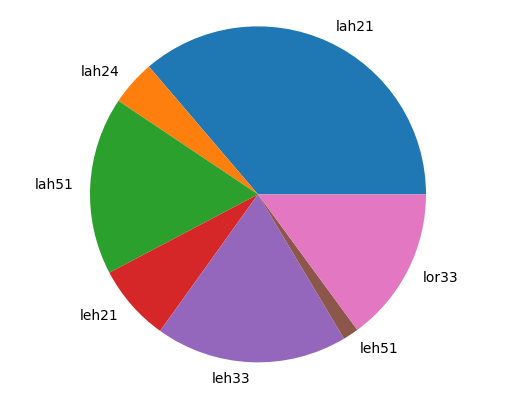

In [ ]:
import matplotlib.pyplot as plt
def plot_data_proportions(listofconvos):
  particles = ["lah21", "lah24","lah51", "leh21", "leh33",  "leh51", "lor33"  ]
  particle_dict = dict(
    [(part, 0) for part in particles]
  )
  for conv in listofconvos:
    for part in particles:
      cnt = conv.count(part)

      particle_dict[part] += cnt


  labels, sizes =  list(zip(*list(particle_dict.items())))
  plt.pie(sizes, labels=labels)

  plt.axis('equal')
  plt.show()
  # total = sum(particle_dict.values())
  # for key in particle_dict:
  #   particle_dict[key] = round(particle_dict[key]/total, 4)


plot_data_proportions(combined_data["train"]["output"])
# import matplotlib.pyplot as plt
# plt.pie(sizes, labels=labels)

# plt.axis('equal')
# plt.show()

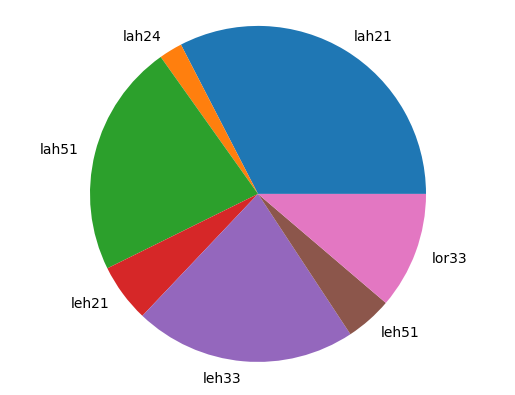

In [ ]:
plot_data_proportions(combined_data["test"]["output"])

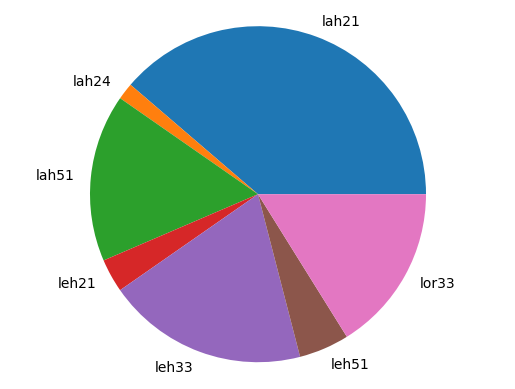

In [ ]:
plot_data_proportions(combined_data["eval"]["output"])

In [ ]:
conv = """
A: You always come late to school. Why leh?
B: I'm sorry teacher, it's because my friend told me to wait.
A: So if I tell you to jump off the building, you jump off the building lah!
"""
user_content = """Singlish is known for the use of particles such as  "lah", "lor" and "leh" and each particle has its own tone. I am going to provide you with a conversation in Singlish. Locate the Singlish particle(s) "lah", "lor" or "leh" and attach the appropriate tone for each particle, taking into account the context of the conversation and mood of the speakers.
  Please reply with the formatted conversation.
  The particle "lah" in Singlish has 3 tonal variations: lah21, lah24 and lah51
  The particle "leh" in Singlish has 3 tonal variations: leh21, leh33, leh51
  The particle "lor" in Singlish has only 1 variation: lor33
  Here is the conversation:\n{conv}
  """

messages = [

      {
          "role": "user",
      "content": user_content.format(conv=conv)

      }
]






def generate_stream(model, messages, max_new_tokens=1000, device="cuda:0", top_p=0.7, temp = 0.7):
  '''tokenise prompt and generate output'''


  config = model.generation_config
  config.max_new_tokens = max_new_tokens
  config.temperature = temp
  config.top_p = top_p
  config.num_return_sequences = 1
  config.pad_token_id = tokenizer.eos_token_id
  config.eos_token_id = tokenizer.eos_token_id

  prompt = tokenizer.apply_chat_template(messages, return_tensors="pt", tokenize=False)
  encoding = tokenizer(prompt, return_tensors="pt").to(device)
  streamer = TextIteratorStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True) # skip prompt?
  generation_kwargs = dict(
      input_ids=encoding.input_ids,
      attention_mask=encoding.attention_mask,
      generation_config=config,
      streamer=streamer,
      eos_token_id = tokenizer.eos_token_id,
      do_sample = True
      )

  with torch.inference_mode():
    thread = Thread(target=model.generate, kwargs=generation_kwargs)
    thread.start()
    outputs = ""
    for new_text in streamer:
      if "[/INST]" not in new_text:
        outputs += new_text
        print(new_text, end="")
      else:
        outputs+= new_text
        print(new_text, end="")
        break

  return outputs # needed for training with accelerate

device = "cuda:0"
out = generate_stream(ft_model, messages)



A: You always come late to school. Why leh33?
B: I'm sorry teacher, it's because my friend told me to wait.
A: So if I tell you to jump off the building, you jump off the building lah21!

  [/INST]


# TESTING AND EDA

In [ ]:
results = {
    "query": [],
    "results": []
}


for row in combined_data["test"]:

  conv = row["conversation"]
  results["query"].append(conv)

  messages = [

      {
          "role": "user",
      "content": user_content.format(conv=conv)

      }
  ]
  device = "cuda"

  out = generate_stream(ft_model, messages)

  results["results"].append(out)






A: I cut until this length ok?
B: Yeah, okay
A: <proceeds to cut hair>
B: Wait wait wait, you are cutting until too short already leh33
  [/INST]


A: Bank robbery leh33, and you dare to tackle the robbers?
B: Yeah, adrenaline rush haha
A: You not scared?
B: I don’t know, before my brain even processed anything, my body already kicked the robber oops
  [/INST]



A: So where are we meeting later?
B: we see how lah21, I go change first and call you before I leave
A: ok fine, faster
  [/INST]



A: Did you enjoy your weekend?
B: I had to take care of the kids and couldn't even go shopping lor33
A: Oh no, do you have any protected alone time at all?
B: Sadly no


A: Hey, where are you right now?
B: I'm at my grandma's house. You leh33?
A: Oh, I'm just at home.
  [/INST]


A: What are you shopping for?
B: Watch lor33
A: I saw a few watches, one I think is quite okay at around $116, but I need a second opinion leh33
B: Ok, let me see, which watch were you looking at?
  [/INST]



A: Huh,

In [ ]:
from datasets import Dataset
rs_ds = Dataset.from_dict(results)
rs_ds.push_to_hub("test", private=True)
combined_data["test"].push_to_hub("private_test", private=True) # expected outputs
#out = generate_stream(ft_model, messages)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/304 [00:00<?, ?B/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/376 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/hyhyhyhyyhyh/private_test/commit/248b73f971f47c4fd4b907a3d405c2afe94a638a', commit_message='Upload dataset', commit_description='', oid='248b73f971f47c4fd4b907a3d405c2afe94a638a', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
rs_ds.push_to_hub("test", private=True) # llm results

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/303 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/hyhyhyhyyhyh/test/commit/0d114b5f5927541f972d2447a2ffcafba791f99c', commit_message='Upload dataset', commit_description='', oid='0d114b5f5927541f972d2447a2ffcafba791f99c', pr_url=None, pr_revision=None, pr_num=None)

# Scoring


In [ ]:
import pandas as pd
import re
df = pd.read_csv("result_df.csv") # rs_ds["results"] and combined_data["test"]["conversation"]
# processed using process_hf_results.py on github

In [ ]:
df['expected_output']

0     \n\nA: I cut until this length ok?\nB: Yeah, o...
1                               \nA: Bank robbery leh51
2     \n\nA: So where are we meeting later?\nB: we s...
3     \n\nA: Did you enjoy your weekend?\nB: I had t...
4     \n\nA: Hey, where are you right now?\nB: I'm a...
5     \n\nA: What are you shopping for?\nB: Watch lo...
6     \n\nA: Huh, are you still doing yesterday's tu...
7     \n\nA: Hey, did you tell Shuhui about the surp...
8     \n\nA: Hey, have you been to Sarah's house? \n...
9     \n\nA: Hey, are you coming to the party tonigh...
10    \n\nA: Photographic society has a meeting on W...
11    \nA: I am so bored today\nB: Then we go watch ...
12    \n\nA: Hey, are you going for the rag day?\nB:...
13    \n\nA: Hey, what have you been up to today, wa...
14    \n\nA: I just ended my reunion dinner, miss yo...
15    \n\nA: There's nothing to eat at home\nB: Oh, ...
16    \n\nA: Hey, do you want to go try the new rest...
17    \n\nA: Hey, are you excited for university

In [ ]:
df['actual_output']

0     \n\n\nA: I cut until this length ok?\nB: Yeah,...
1     \n\nA: Bank robbery leh33, and you dare to tac...
2     \n\n\nA: So where are we meeting later?\nB: we...
3     \n\n\nA: Did you enjoy your weekend?\nB: I had...
4     \n\n\nA: Hey, where are you right now?\nB: I'm...
5     \n\n\nA: What are you shopping for?\nB: Watch ...
6     \n\n\nA: Huh, are you still doing yesterday's ...
7     \n\n\nA: Hey, did you tell Shuhui about the su...
8     \n\n\nA: Hey, have you been to Sarah's house? ...
9     \n\n\nA: Hey, are you coming to the party toni...
10    \n\n\nA: Photographic society has a meeting on...
11    \n\nA: I am so bored today\nB: Then we go watc...
12    \n\n\nA: Hey, are you going for the rag day?\n...
13    \n\n\nA: Hey, what have you been up to today, ...
14    \n\n\nA: I just ended my reunion dinner, miss ...
15    \n\n\nA: There's nothing to eat at home\nB: Oh...
16    \n\n\nA: Hey, do you want to go try the new re...
17    \n\n\nA: Hey, are you excited for universi

In [ ]:
def extract_particles(text):
  LIST_OF_PARTICLES = [r'lah\d{2}', r'lor\d{2}', r'leh\d{2}']
  pattern = r"\b" + "|".join(LIST_OF_PARTICLES)  + r"\b"
  return re.findall(pattern, text)

# TEST
extract_particles("walao lah21 leh33, you lah21, ofc you lor33")

['lah21', 'leh33', 'lah21', 'lor33']

In [ ]:
total_score = len(df['actual_output'])
curr_scores = []
for i in range(total_score):
  if df['expected_output'][i] in df['actual_output'][i]:
    curr_scores.append(1)
    # if they are equal, barring the extra [/INST] generated by the model
  else:
    expected_particles = extract_particles( df['expected_output'][i])
    actual_particles = extract_particles( df['actual_output'][i])
    print("Particles, expected then actual")
    print(expected_particles)
    print(actual_particles)
    print("Conversation, expected then actual")
    print(df['expected_output'][i] )
    print(df['actual_output'][i])

    rating = float(input("How much should the model get? 0-1: "))
    while not (0 <= rating <= 1):
      rating = float(input("How much should the model get? 0-1: "))
    curr_scores.append(rating)

    print("====END ROW====")


print("TOTAL SCORE")

df["scores"] = pd.Series(curr_scores)
df.to_csv("result_df_scores.csv")

Particles, expected then actual
['leh51']
['leh33']
Conversation, expected then actual


A: I cut until this length ok?
B: Yeah, okay
A: <proceeds to cut hair>
B: Wait wait wait, you are cutting until too short already leh51



A: I cut until this length ok?
B: Yeah, okay
A: <proceeds to cut hair>
B: Wait wait wait, you are cutting until too short already leh33
  [/INST]

How much should the model get? 0-1: 0
====END ROW====
Particles, expected then actual
['leh51']
['leh33']
Conversation, expected then actual

A: Bank robbery leh51


A: Bank robbery leh33, and you dare to tackle the robbers?
B: Yeah, adrenaline rush haha
A: You not scared?
B: I don’t know, before my brain even processed anything, my body already kicked the robber oops
  [/INST]

How much should the model get? 0-1: 0
====END ROW====
Particles, expected then actual
['lor33', 'leh21']
['lor33', 'leh33']
Conversation, expected then actual


A: What are you shopping for?
B: Watch lor33
A: I saw a few watches, one I think i

In [ ]:
df.to_csv

,Unnamed: 0,expected_output,actual_output,scores
0,0,"\n\nA: I cut until this length ok?\nB: Yeah, o...","\n\n\nA: I cut until this length ok?\nB: Yeah,...",0.000
1,1,\nA: Bank robbery leh51,"\n\nA: Bank robbery leh33, and you dare to tac...",0.000
2,2,\n\nA: So where are we meeting later?\nB: we s...,\n\n\nA: So where are we meeting later?\nB: we...,1.000
3,3,\n\nA: Did you enjoy your weekend?\nB: I had t...,\n\n\nA: Did you enjoy your weekend?\nB: I had...,1.000
4,4,"\n\nA: Hey, where are you right now?\nB: I'm a...","\n\n\nA: Hey, where are you right now?\nB: I'm...",1.000
5,5,\n\nA: What are you shopping for?\nB: Watch lo...,\n\n\nA: What are you shopping for?\nB: Watch ...,0.500
6,6,"\n\nA: Huh, are you still doing yesterday's tu...","\n\n\nA: Huh, are you still doing yesterday's ...",0.500
7,7,"\n\nA: Hey, did you tell Shuhui about the surp...","\n\n\nA: Hey, did you tell Shuhui about the su...",0.500
8,8,"\n\nA: Hey, have you been to Sarah's house? \n...","\n\n\nA: Hey, have you been to Sarah's house? ...",0.500
9,9,"\n\nA: Hey, are you coming to the party tonigh...","\n\n\nA: Hey, are you coming to the party toni...",0.000
